In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

(segmentation)=
# Image segmentation

The general scope of image processing and some basic terminology were introduced
in {numref}`skimage`. We will now dive deeper into specific image processing
methods in a bit more detail. We are going to look at computational tasks that
are in common use in neuroimaging data analysis and we are going to demonstrate
some solutions to these problems using relatively simple computations.

The first is image segmentation. Image segmentation divides the pixels or voxels
of an image into different groups. For example, you might divide a neuroimaging
dataset into parts that contain the brain itself and parts that are non-brain
(e.g., background, skull, etc.). Generally speaking, segmenting an image allows
us to know where different objects are in an image and allows us to separately
analyze parts of the image that contain particular objects of interest. Let's
look at a specific example. We'll start by loading a neuroimaging dataset that
has BOLD fMRI images in it:

In [2]:
from ndslib import load_data
brain = load_data("bold_volume")

For simplicity's sake, we will look only at one slice of the data for now. Let's
take a horizontal slice roughly in the middle of the brain. Visualizing the
image can help us understand the challenges that segmentation helps us tackle.

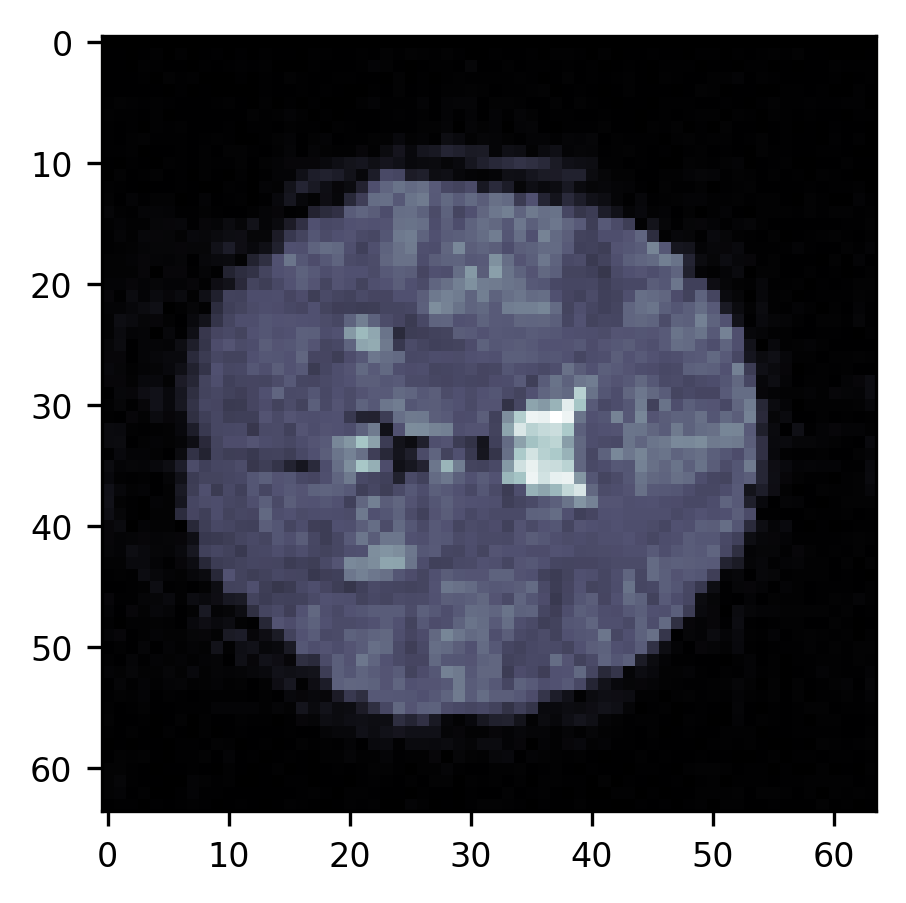

In [3]:
slice10 = brain[:, :, 10]
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(slice10, cmap="bone")

First of all, a large part of the image is in the background -- the air around
the subject's head. If we are going to do statistical computations on the data
in each of the voxels, we would like to avoid looking at these voxels. That
would be a waste of time. In addition, there are parts of the image that are not
clearly in the background but contain parts of the subject's head or parts of
the brain that we are not interested in. For example, we don't want to analyze
the voxels that contain parts of the subject's skull and/or skin that appear as
bright lines alongside the top of the part of the image that contains the brain.
We also don't want to analyze the voxels that are in the ventricles, appearing
here as brighter parts of the image. To be able to select only the voxels that
are in the brain proper, we need to segment the image into brain and non-brain.
There are a few different approaches to this problem.

## Intensity-based segmentation

The first and simplest approach to segmentation is to use the distribution of
pixel intensities as a basis for segmentation As you can see, the parts of the
image that contain the brain are brighter -- have higher intensity values. The
parts of the image that contain the background are dark and contain
low-intensity values. One way of looking at the intensity values in the image is
using a histogram. This code displays a histogram of pixel intensity values. I
am using the Matplotlib "hist" function, which expects a one-dimensional array
as input, so the input is the "flat" representation of the image array, which
unfolds the two-dimensional array into a one-dimensional array.

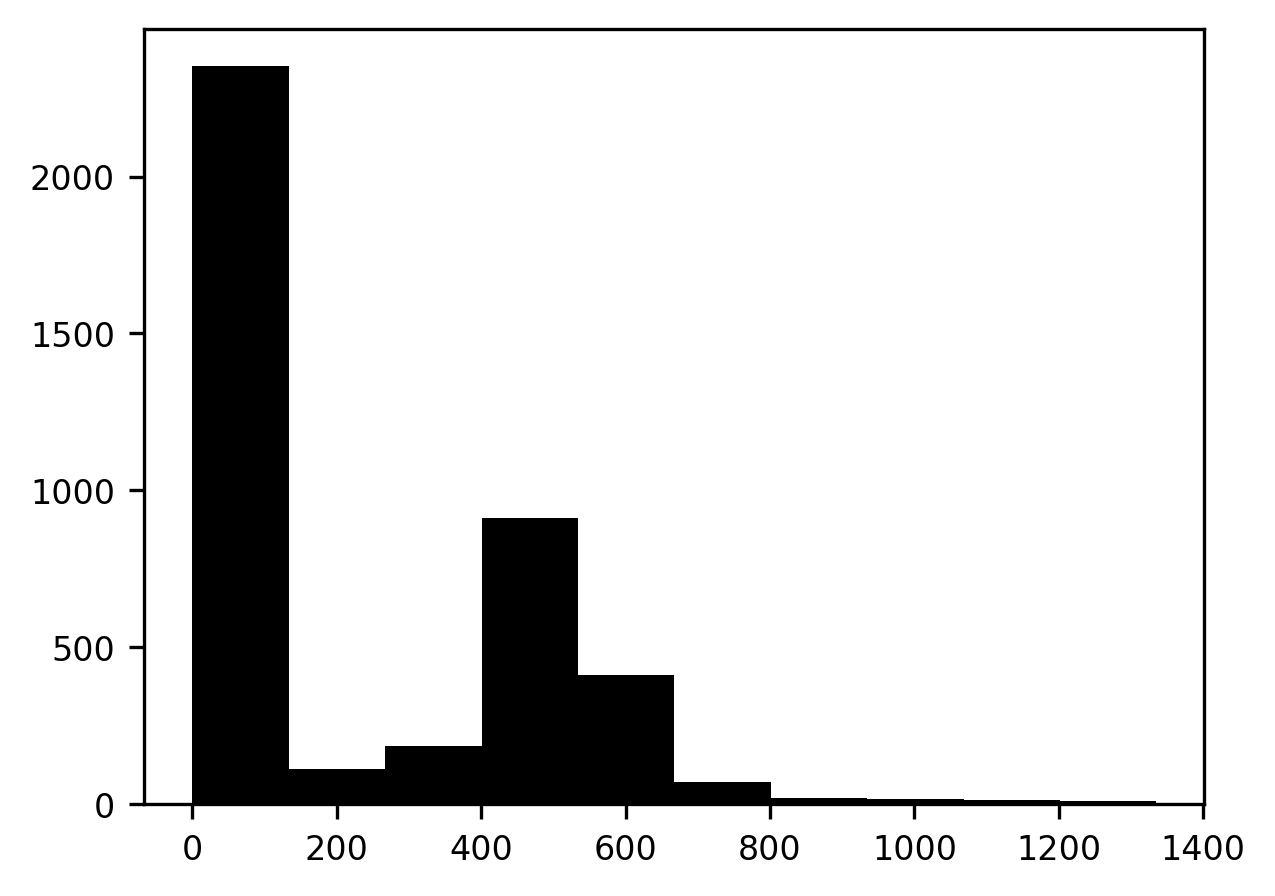

In [4]:
fig, ax = plt.subplots()
p = ax.hist(slice10.flat)

The histogram has two peaks. A peak at lower pixel intensity values, close to 0,
corresponds to the dark part of the image that contains the background, and a
peak at higher intensity values, corresponds to the bright part of the image
that contains the brain

One approach to segmentation would be to find a threshold value. Pixels with
values below this threshold would be assigned to the background and values equal
to or above this threshold would be assigned to the brain

For example, we can select the mean pixel intensity to be our threshold. Here, I
am displaying the image intensity histogram, together with the mean value,
represented as a vertical dashed line. What would a segmentation based on this
value look like?

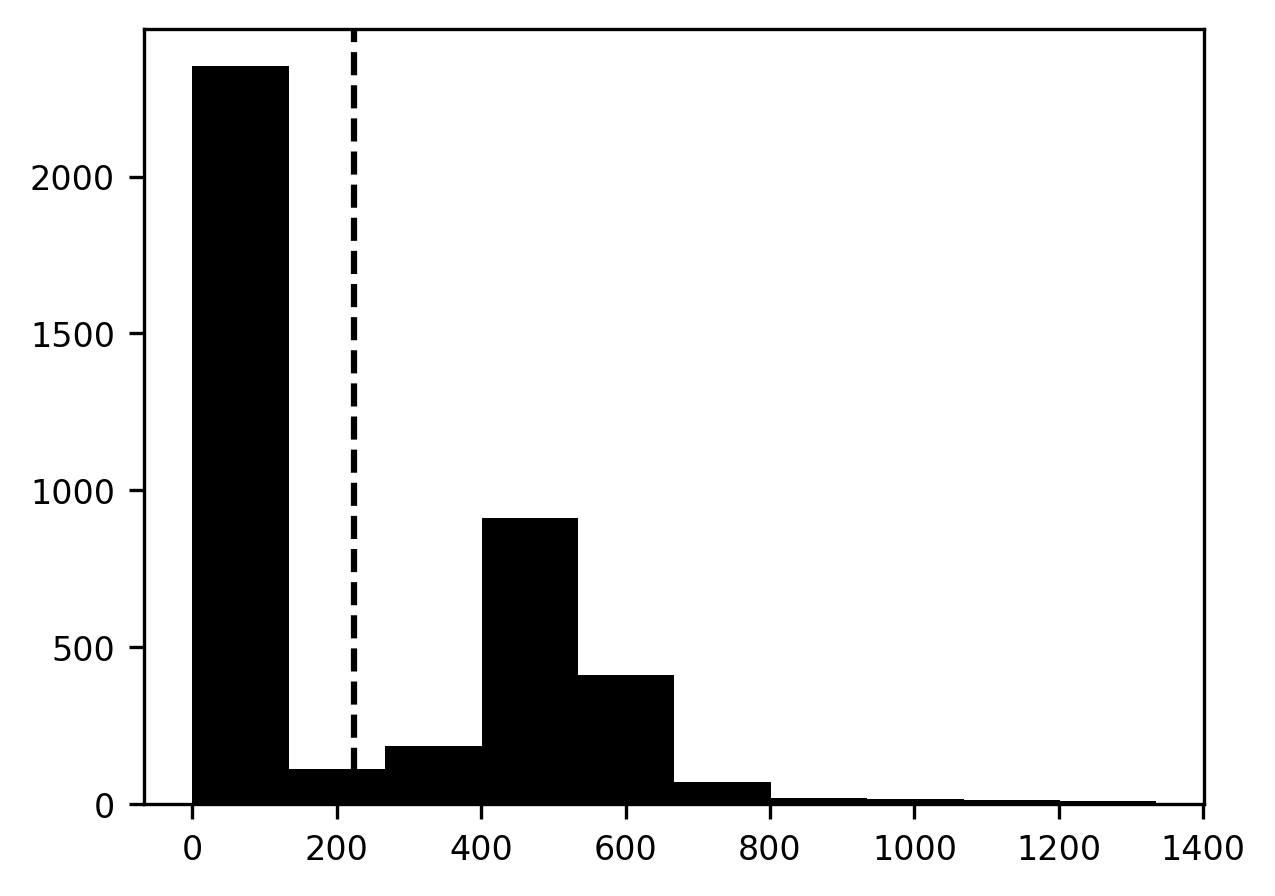

In [5]:
import numpy as np
mean = np.mean(slice10)
fig, ax = plt.subplots()
ax.hist(slice10.flat)
p = ax.axvline(mean, linestyle='dashed')

We start by creating a segmentation image that contains all zeros. Using
Boolean indexing, we select those parts of the segmentation image that
correspond to parts of the brain image that have intensities higher than the
threshold and set these to 1 (see also {numref}`boolean_indexing_numpy`). Then, we
can display this image on top of our brain image. To make sure that we can see
the brain image through the segmentation image, we set it to be slightly
transparent. This is done by setting an imaging parameter called "alpha", which
describes the opacity of an image (where 0 is fully transparent and 1.0 is fully
opaque) to 0.5. This lets us see how well the segmentation overlaps with the
brain image.

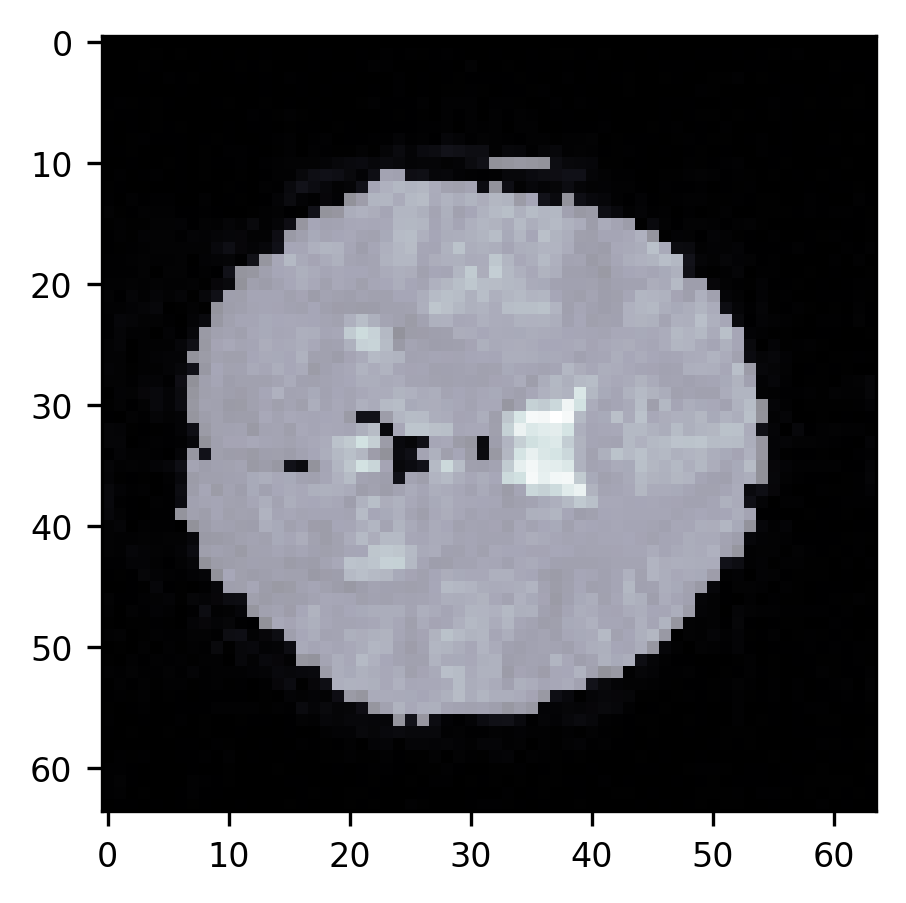

In [6]:
segmentation = np.zeros_like(slice10)
segmentation[slice10 > mean] = 1

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
im = ax.imshow(segmentation, alpha=0.5)

With this visualization, we can see the brain through the transparency of the
segmentation mask. We can see that the mean threshold is already pretty
effective at segmenting out parts of the image that contain the background, but
there are still parts of the image that should belong to the background and are
still considered to be part of the brain. In particular, parts of the skull and
the dura mater get associated with the brain, because they appear bright in the
image. Also, the ventricles, which appear brighter in this image, are classified
as part of the brain. The challenge is to find a value of the threshold that
gives us a better segmentation.

(otsu)=
### Otsu's method

```{eval-rst}
.. index::
   single: Otsu's method
```

```{eval-rst}
.. index::
   single: Otsu, Nobuyuki
```

A classic approach to this problem is now known as "Otsu's method", after the
Japanese engineer Nobuyuki Otsu, who invented it in the 1970s {cite}`otsu1979`.
The method relies on a straightforward principle: find a threshold that
minimizes the variance in pixel intensities within each class of pixels (for
example, brain and non-brain). This principle is based on the idea that pixels
within each of these segments should be as similar as possible to each other,
and as different as possible from the other segment. It also turns out that this
is a very effective strategy for many other cases where you would like to
separate the background from the foreground (for example, text on a page).

Let's examine this method in more detail. We are looking for a threshold that
would minimize the total variance in pixel intensities within each class, or
"intraclass variance". This has two components: The first is the variance of
pixel intensities in the background pixels, weighted by the proportion of the
image that is in the background. The other is the variance of pixel intensities
in the foreground, weighted by the proportion of pixels belonging to the
foreground. To find this threshold value, Otsu's method relies on the following
procedure: Calculate the intraclass variance for every possible value of the
threshold and find the candidate threshold that corresponds to the minimal
intraclass variance. We will look at an example with some code below, but we
will first describe this approach in even more detail with words.

We want to find a threshold corresponding to as small as possible intraclass
variance, so we start by initializing our guess of the intraclass variance to
the largest possible number: infinity. We are certain that we will find a value
of the threshold that will have a smaller intraclass variance than that. Then,
we consider each possible pixel value that could be the threshold. In this case,
that's every unique pixel value in the image (which we find using `np.unique`).
As background, we select the pixel values that have values lower than the
threshold. As foreground, we select the values that have values equal to or
higher than the threshold.

Then, the foreground contribution to the intraclass variance is the variance of
the intensities among the foreground pixels (`np.var(foreground`), multiplied by
the number of foreground pixels (`len(foreground)`). The background contribution
to the intraclass variance is the variance of the intensities in the background
pixels, multiplied by the number of background pixels (with very similar code
for each of these). The intraclass variance is the sum of these two. If this
value is smaller than the previously found best intraclass variance, we set this
to be the new bests intraclass variance, and replace our previously found
threshold with this one. After running through all the candidates, the value
stored in the threshold variable will be the value of the candidate that
corresponds to the smallest possible intraclass variance.

This is the value that you would use to segment the image. Let's look at the
implementation of this algorithm

In [7]:
min_intraclass_variance = np.inf

for candidate in np.unique(slice10):
    foreground = slice10[slice10 < candidate]
    background = slice10[slice10 >= candidate]
    if len(foreground) and len(background):
        foreground_variance = np.var(foreground) * len(foreground)
        background_variance =  np.var(background) * len(background)
        intraclass_variance = foreground_variance + background_variance
        if intraclass_variance < min_intraclass_variance:
            min_intraclass_variance = intraclass_variance
            threshold = candidate

Having run through this, let's see if we found something different from our
previous guess -- the mean of the pixel values. We add this value to the
histogram of pixel values as a dotted line. It looks like the value that Otsu's
method finds is a bit higher than the mean pixel value.

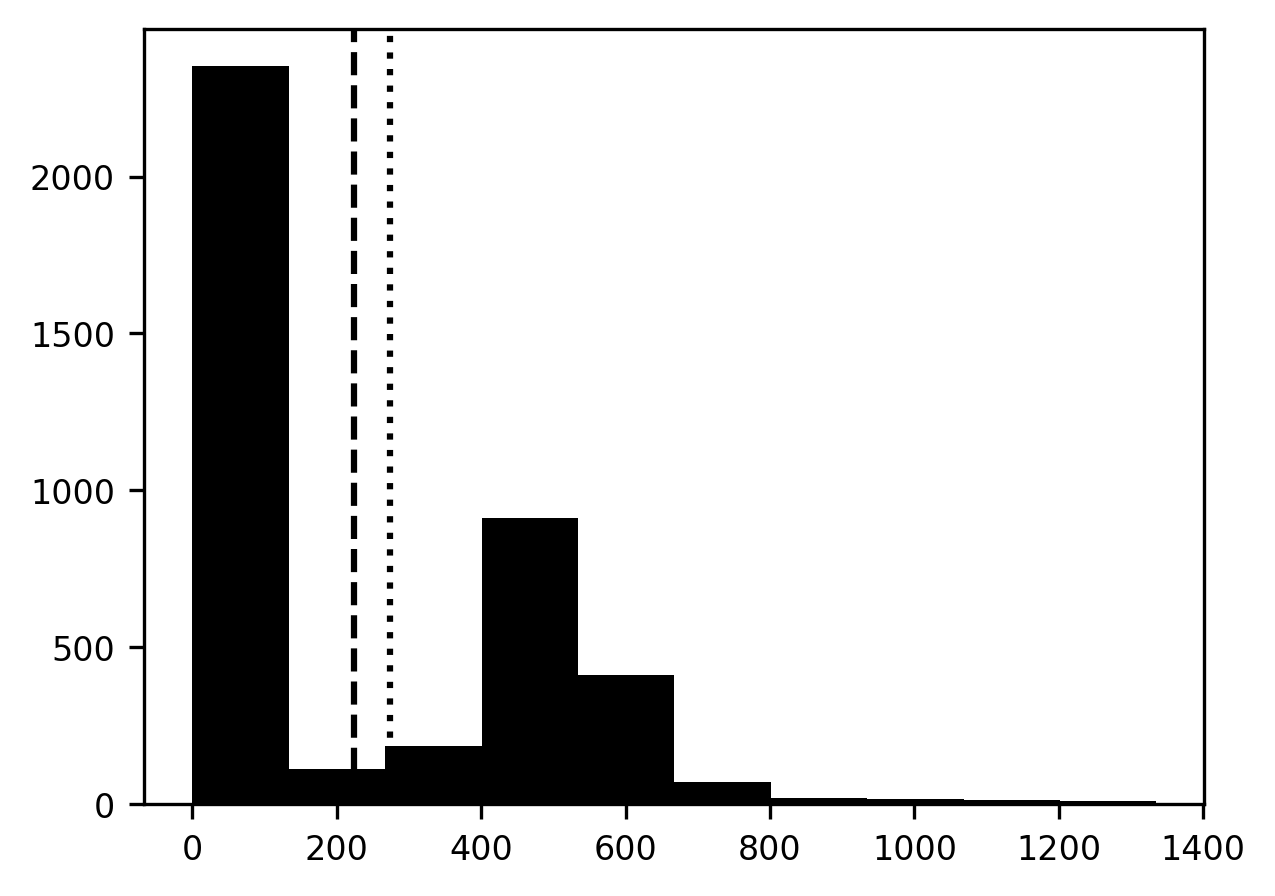

In [8]:
mean = np.mean(slice10)
fig, ax = plt.subplots()
ax.hist(slice10.flat)
ax.axvline(mean, linestyle='dashed')
p = ax.axvline(threshold, linestyle='dotted')

How well does this segmentation strategy work?

We'll use the same code we used before, creating an array of zeros, and
replacing the zeros with ones only in those parts of the array that correspond
to pixels in the image that have values smaller than the threshold.

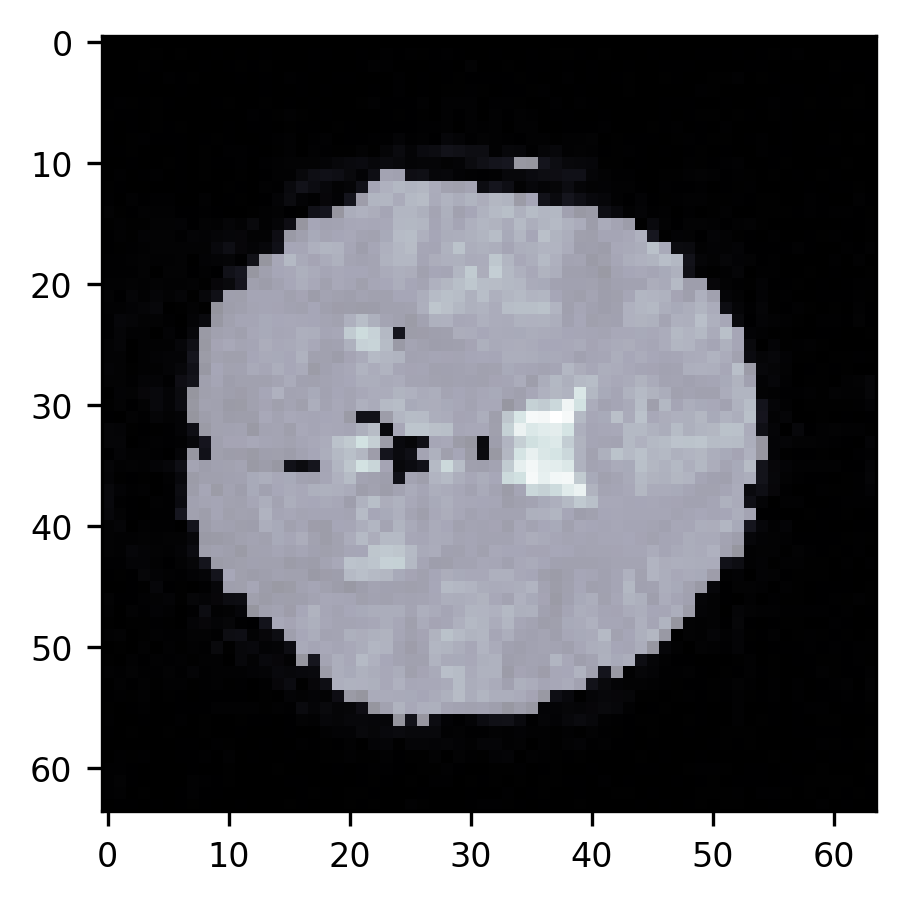

In [9]:
segmentation = np.zeros_like(slice10)
segmentation[slice10 > threshold] = 1

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
p = ax.imshow(segmentation, alpha=0.5)

As you can see, this segmentation is quite good. There are almost no more voxels
outside the brain that are misclassified as being in the brain. We still have
trouble with the ventricles, though. This highlights the limitation of this
method. In particular, a single threshold may not be enough. In the exercise
below, you will be asked to think about this problem more, but before we move on
and talk about other approaches to segmentation, we'll just point out that if
you do want to use Otsu's method for anything, you should probably use the
Scikit Image implementation of it, which is in `skimage.filters.threshold_otsu`.
It's much faster and more robust than the simple implementation we outlined
above. If you want to learn more about how to speed up slow code, reading
through the source code of this function [^1] is an interesting case study.

[^1]: Available at https://github.com/scikit-image/scikit-image/blob/v0.19.3/skimage/filters/thresholding.py#L312


(segmentation_ex1)=
#### Exercises

1. Using the code that we implemented above, implement code that finds two threshold values to segment the brain slice into three different segments. Does this adequately separate the ventricles from other brain tissue based on their intensity? Compare the performance of your implementation to the results of Scikit Image's `skimage.filters.threshold_multiotsu`.

2. The `skimage.filters` module has a function called `try_all_threshold`, which compares several different approaches to threshold-based segmentation. Run this function to compare the methods. Which one works best on this brain image? How would you evaluate that objectively?

```{admonition} Image processing, computer vision and neuroscience

There has always been an interesting link between image processing and neuroscience. This is because one of the goals of computational image processing is to create algorithms that mimic operations that our eyes and brain can easily do. For example, the segmentation task that we are trying to automate in this chapter is one that our visual system can learn do with relative ease. One of the founders of contemporary computational neuroscience was David Marr. One of his main contributions to computational neuroscience was in breaking apart problems in neuroscience conceptually to three levels: computational, algorithmic and implementational. The computational level can be thought of as the purpose of the system, or the problem that the system is solving. The algorithmic level is a series of steps or operations -- ideally defined mathematically -- that the system can take to solve the problem. Finally, the implementation level is the specific way in which the algorithm is instantiated in the circuitry of the nervous system. This view of neuroscience has been hugely influential and has inspired both efforts to understand the nervous system based on predictions from both the computational and algorithmic levels, as well as efforts to develop algorithms that are inspired by the architecture of the brain. For example, in 1980, Marr and Ellen Hildreth wrote a paper that described the theory of edge detection and also proposed an algorithm that finds edges in images {cite}`Marr1980-ls`. Their premise was that the computational task that is undertaken by the first few stages in the visual system is to construct a "rich but primitive description of the image". What they called the "raw primal sketch" should provide the rest of the visual system -- the parts that figure out what objects are out in the world and what they are doing -- with information about things like edges, surfaces and reflectances. Based on this computational requirement, they designed an algorithm that would specialize at finding edges. This was a particular kind of filter/kernel that, when convolved with images, would find the parts of the image where edges exist. Based on some theoretical considerations they defined this kernel to be a difference of two Gaussians with two different variances. This edge detector was inspired to some degree by the operations that Marr and Hildreth knew that the early visual cortex performs. In addition, their article proposed some predictions for what operations the visual system should be doing if this is the way that it indeed performs edge detection.
```

```{eval-rst}
.. index::
   single: Marr, David
```

```{eval-rst}
.. index::
   single: Hildreth, Ellen
```


## Edge-based segmentation

Threshold-based segmentation assumes that different parts of the image that
should belong to different segments should have different distributions of pixel
values. In many cases that is true. But this approach does not take advantage of
the spatial layout of the image. Another approach to segmentation uses the fact
that parts of the image that should belong to different segments are usually
separated by edges. What is an edge? Usually, these are contiguous boundaries
between parts of the image that look different from each other. These
differences can be differences in intensity, but also differences in texture,
pattern, and so on. In a sense, finding edges and segmenting the image are a bit
of a chicken and egg: if you knew where different parts of the image were, you
wouldn't have to segment them. Nevertheless, in practice, using algorithms that
specifically focus on finding edges in the image can be useful to perform the
segmentation. Finding edges in images has been an important part of computer
vision for about as long as there has been a field called computer vision. As
you saw in chapter {numref}`skimage`, one part of finding edges could be to
construct a filter that emphasizes changes in the intensity of the pixels (such
as the Sobel filter that you explored in the exercise in
{numref}`sobel_exercise`). Sophisticated edge detection algorithms can use this,
together with a few more steps, to more robustly find edges that extend in
space. One such algorithm is the Canny edge detector, named after its inventor,
John Canny, a computer scientist, and computer vision researcher
{cite}`Canny1986-pq`. The algorithm takes several steps that include smoothing
the image to get rid of noisy or small parts, finding the local gradients of the
image (for example, with the Sobel filter) and then thresholding this image,
selecting edges that are connected to other strong edges and suppressing edges
that are connected to weaker edges. We will not implement this algorithm step by
step, but instead, use the algorithm as it is implemented in Scikit Image. If you
are interested in learning more about the algorithm and would like an extra
challenge, we would recommend also reading through the source code of the Scikit
Image implementation [^2]. It's just a few dozen lines of code, and understanding
each step that the code is taking will help you understand this method much
better. For now, we will use this as a black box and see whether it helps us
with the segmentation problem. We start by running our image through the canny
edge detector. This creates an image of the edges, containing a 1 in locations
that are considered to be at an edge and 0 in all other locations.

[^2]: Available at https://github.com/scikit-image/scikit-image//blob/v0.19.3/skimage//feature/_canny.py#L205

```{eval-rst}
.. index::
   single: Canny filter
```

```{eval-rst}
.. index::
   single: Canny, John
```

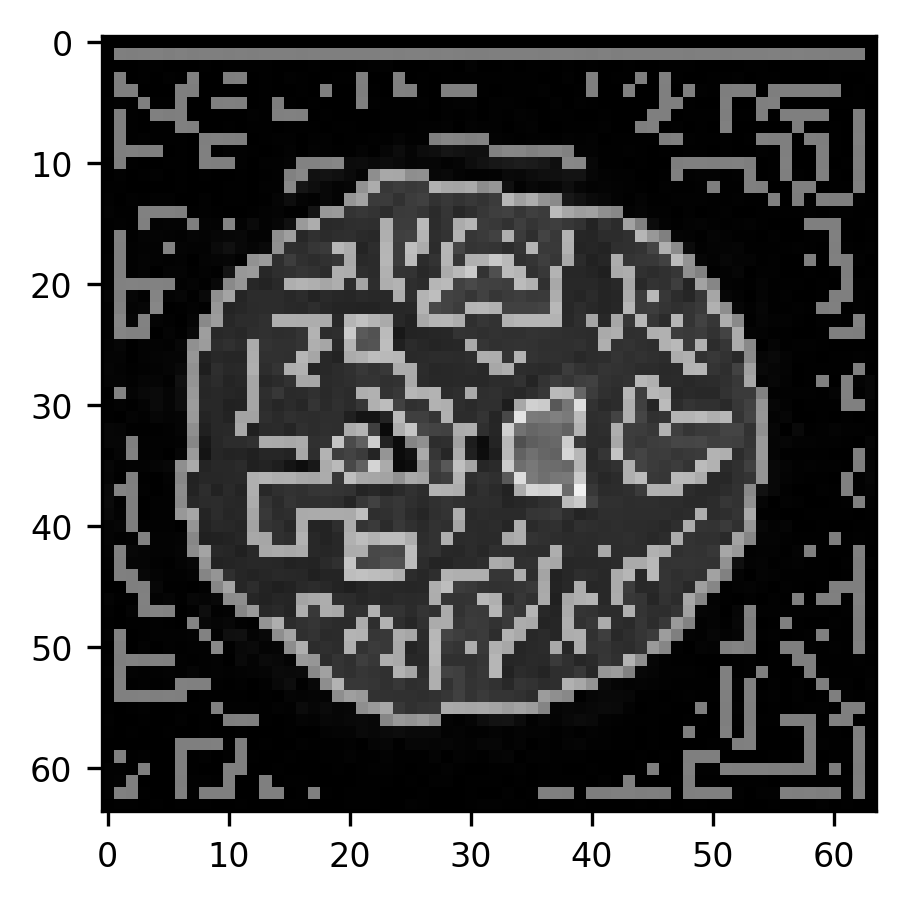

In [10]:
from skimage.feature import canny
edges = canny(slice10)

fig, ax = plt.subplots()
ax.imshow(slice10, cmap="gray")
im = ax.imshow(edges, alpha=0.5)

As you can see, the algorithm finds edges both around the perimeter of the brain
as well as within the brain. This just shows us that the Canny algorithm is
very good at overcoming one of the main challenges of edge detection, which is
that edges are defined by intensity gradients across a very large range of
different intensities. That is, an edge can be a large difference between very
low pixel intensities (for example, between the background and the edge of the
brain) as well as between very high pixel intensities (parts of the brain and
the ventricles). Next, we will use some morphological operations to fill parts
of the image that are enclosed within edges and to remove smaller objects that
are spurious (see {numref}`morphology`).

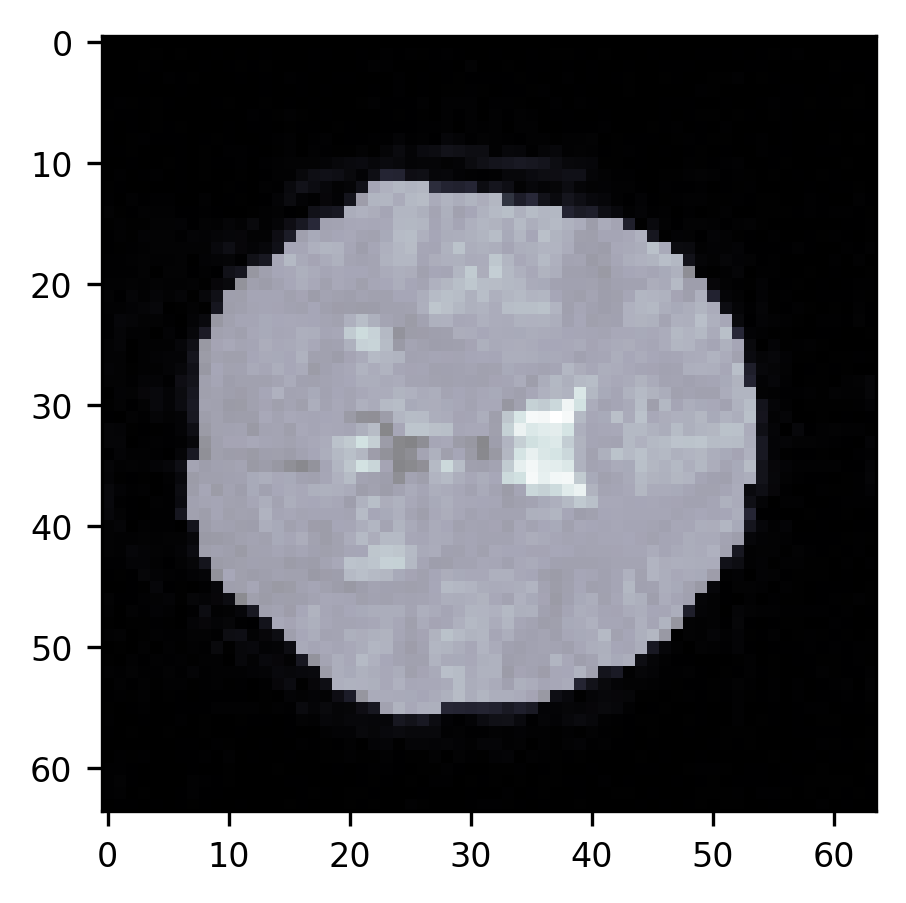

In [11]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import erosion, remove_small_objects
segmentation = remove_small_objects(erosion(binary_fill_holes(edges)))
fig, ax = plt.subplots()
ax.imshow(slice10, cmap="bone")
im = ax.imshow(segmentation, alpha=0.5)

This approach very effectively gets rid of the parts of the skull around the
brain, but it does not separate the ventricles from the rest of the brain. It
also doesn't necessarily work as well in other slices of this brain (as an
exercise, try running this sequence of commands on other slices. When does it
work well? When does it fail?). Brain data segmentation is a very difficult
task. Though we introduced a few approaches here, we don't necessarily recommend
that you rely on these approaches as they are. The algorithms that are used in
practice to do brain segmentations rely not only on the principles that we showed here but also on knowledge of brain structure and extensive validation experiments. Segmentation of brain data into multiple structures and tissue types, as done, for example, by the popular [Freesurfer software](https://surfer.nmr.mgh.harvard.edu/), requires such knowledge. But this does demonstrate a few of the fundamental operations
that you might use if you were to start down your path of developing such
algorithms for new use cases.

```{eval-rst}
.. index::
   single: Freesurfer
```

## Additional resources

Both Nobuyuki Otsu's original description of Otsu's method {cite}`otsu1979` and
John Canny's original description of the Canny filter {cite}`Canny1986-pq` are
good reads if you want to understand the use cases and development of this kind
of algorithm and of image-processing pipelines more generally.